# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

## Completed by Stephen Fox

### July 2016

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [3]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [40,200,400]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,24025,4332,4757,9510,1145,5864
1,3067,13240,23127,3941,9959,731
2,4446,906,1238,3576,153,1014


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

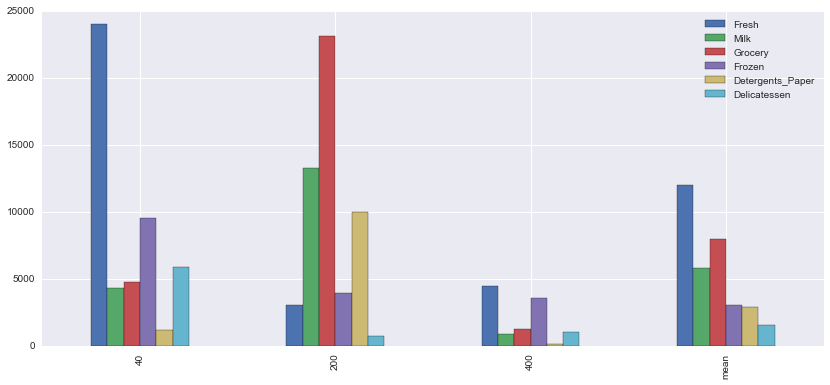

In [4]:
# Visualize the amount of product per sample, prior to answering the question:

import seaborn as sns
samples_bar = samples.append(data.describe().loc['mean'])
samples_bar.index = indices + ['mean']
_ = samples_bar.plot(kind='bar', figsize=(14,6))

**Answer:**

Sample 0 (#40) could be a high-end restaurant, since they have a 'fresh' and 'frozen' spend in excess of the 75th percentile of all customers and thus could fit the profile of an establishment preparing fresh meals daily. 

Sample 1 (#200) could be a small grocery store (i.e. a 'corner store' meant for small or emergency purchases), given that they procure a disproportionately low amount of 'fresh' and 'deli' product and a disproportionately high amount of 'milk', 'grocery', 'frozen' and 'detergents_paper', which are four categories that one might often run to the corner store to buy, instead of undertaking the hassle of heading to a large grocery store.

Sample 2 (#400) could be an ice cream parlor. They purchase 'frozen' product (for example, ice cream) at a level in excess of the 75th percentile, but all other categories are near or below the median. This would be consistent with an ice cream store, which requires a great deal of frozen product and a little bit of everything else.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature

new_data = data.drop('Grocery',axis=1)
new_label = data['Grocery']

# TODO: Split the data into training and testing sets using the given feature as the target

X_train, X_test, y_train, y_test = train_test_split(
    new_data, new_label, test_size=0.25, random_state=1)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=2)

regressor.fit(X_train,y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test,y_test)
print "The R^2 for this model is:", score

The R^2 for this model is: 0.822788157911


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

The model has a relatively high coefficient of determination (0.82) when the 'Grocery' feature is used as the predicted feature. This implies that the amount spent by customers on the 'Grocery' feature can be predicted relatively accurately from one or more of the other features and hence 'Grocery' is not likely to be very relevant for identifying the spending habits of customers and customer segments, since one or more of the other features are predictive of the 'Grocery' spend.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

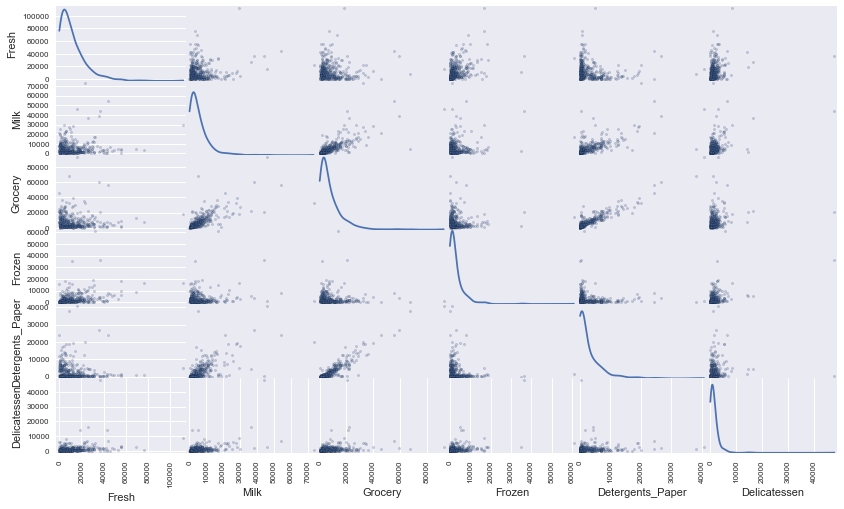

In [7]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**

There appear to be positive correlations between 'Grocery', 'Milk' and 'Detergents_Paper'. So the particular pairs exhibiting positive correlations are:

'Grocery':'Milk'

'Grocery':'Detergents_Paper'

'Milk':'Detergents_Paper'

This confirms my suspicion about the 'Grocery' feature, namely that it is not highly relevant for segmenting: if it were dropped, 'Milk' and 'Detergents_Paper' or a combination thereof, would have the ability to predict similar segmentation as 'Grocery', given the correlations. As the spend increases in any one of these features, it tends to increase in the other feature as well. 

The data is not normally distributed, it is positively (right) skewed, as would be expected from the summary statistics displayed earlier, which indicated that the average exceeded the median for all six features. Most of the data points lie on the lower end of the dollar range, with a long tail on the higher end of the dollar range.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

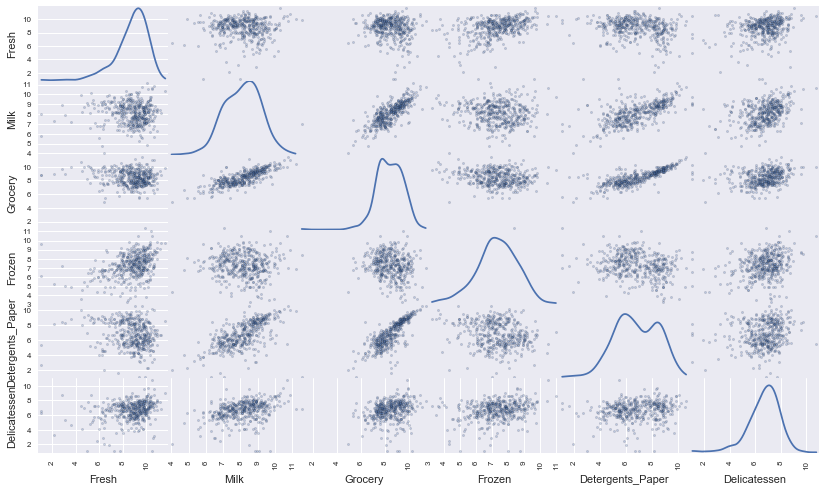

In [8]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [9]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.086850,8.373785,8.467372,9.160099,7.043160,8.676587
1,8.028455,9.490998,10.048756,8.279190,9.206232,6.594413
2,8.399760,6.809039,7.121252,8.182000,5.030438,6.921658


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
122,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101
177,9.453992,8.899731,8.419139,7.468513,2.995732,7.875119
204,7.578657,6.792344,8.561401,7.232010,1.609438,7.191429
237,9.835851,8.252707,6.385194,8.441176,3.332205,7.102499
289,10.663966,5.655992,6.154858,7.235619,3.465736,3.091042
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372
233,6.871091,8.513988,8.106515,6.842683,6.013715,1.945910


Outlier points for more than 1 feature: [ 66  75 142 154 289 338]
Number of customers removed as outliers: 27
Plot the data with the outliers removed:


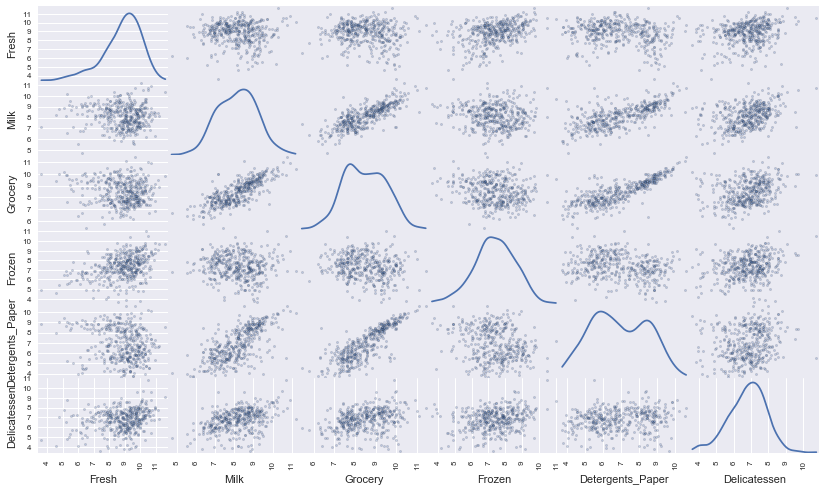

In [10]:
# Create an array of all outliers
all_outliers = np.array([], dtype='int64')

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data,25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data,75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    outlier_points = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    
    all_outliers = np.append(all_outliers, outlier_points.index.values.astype('int64'))
    
    # Display the outliers
    
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = [38,65,66,75,95,96,109,122,128,137,142,154,
             161,177,184,187,203,204,218,233,237,285,289,338,356,402,420]

# Count the unique elements in the all_outliers array
all_outlier, indices = np.unique(all_outliers, return_inverse=True)
counts = np.bincount(indices)

# Obtain outliers using the counts
outliers_multi = all_outlier[counts>1]
print "Outlier points for more than 1 feature:", outliers_multi

print "Number of customers removed as outliers:", len(outliers)

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

print "Plot the data with the outliers removed:"

pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.*

**Answer:**

Using Tukey's Method, 27 outliers were identified, representing 6% of the datapoints (27/440). Of these 27 outliers, the following 6 data points were outliers for two different features: 

66, 75, 142, 154, 289, 338

In the code blocks below, summary statistics for the datasets with and without outliers are provided.

I have chosen to remove all 27 outliers, including those 6 that are outliers for more than 1 feature. My rationale is that in all 27 cases, the outliers were identified for being extremely small in their given category, as shown in the tables above. You can also see this effect from the fact that the 'max' value in the log_data and good_data sets are unchanged, whereas the 'min' value changed for all six features. Also, excluding the 27 outliers did not significantly change the mean of the various categories by any more than 1.8% (as seen by the ratio of means printed below), and hence their exclusion has not significantly shifted the distribution.  

Since the end goal of this analysis is to help the client segment their customers with a goal of maximizing profitability, it is acceptable in my opinion to discard outliers that tended towards the lower end of the sales spectrum in a given category, while not significantly moving the mean of any other category.

In [11]:
print "Data Statistics Including Outliers:"
display(log_data.describe())

print "\n" 
print "Data Statistics Excluding Outliers (identified using Tukey's Method):"
display(good_data.describe())

print "Ratio of Category Means (Data without outliers : All Data):", 
good_data.mean() / log_data.mean()

Data Statistics Including Outliers:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768




Data Statistics Excluding Outliers (identified using Tukey's Method):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,8.834440,8.153897,8.475086,7.358811,6.890081,6.786565
std,1.259416,1.032479,1.020776,1.231881,1.578477,1.090046
min,3.610918,4.718499,5.407172,3.637586,3.713572,3.610918
25%,8.121480,7.383989,7.675546,6.664409,5.616771,6.077642
50%,9.060331,8.198089,8.466742,7.389564,6.719013,6.902743
75%,9.737020,8.868976,9.278373,8.198364,8.295049,7.516433
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


Ratio of Category Means (Data without outliers : All Data):

Fresh               1.011900
Milk                1.004045
Grocery             1.004018
Frozen              1.007864
Detergents_Paper    1.015342
Delicatessen        1.018219
dtype: float64

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

Explained Variance in the six PCs: [ 0.4694499   0.26431247  0.10676028  0.09694678  0.04168644  0.02084413]


Variance explained by 1st and 2nd PCs: 0.733762370283


Variance explained by 1st through 4th PCs: 0.937469430353


Cumulative variance explained by the PCs:
Dimension 1    0.4694
Dimension 2    0.7337
Dimension 3    0.8405
Dimension 4    0.9374
Dimension 5    0.9791
Dimension 6    0.9999
Name: Explained Variance, dtype: float64


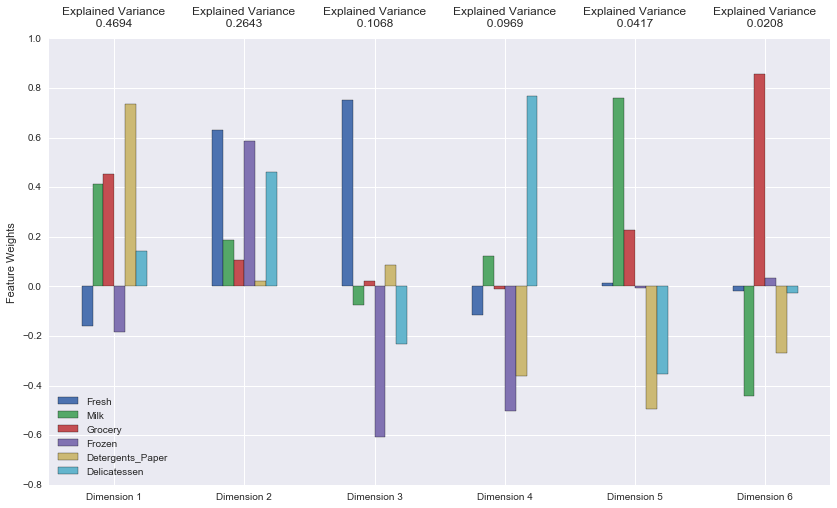

In [12]:
from sklearn.decomposition import PCA

# TODO: Apply PCA to the good data with the same number of dimensions as features
pca = PCA(n_components=6).fit(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

# Code to summarize explained variance of PCs:


print "Explained Variance in the six PCs:", pca.explained_variance_ratio_
print '\n'

pc1_var = pca.explained_variance_ratio_[0]
pc2_var = pca.explained_variance_ratio_[1]
pc3_var = pca.explained_variance_ratio_[2]
pc4_var = pca.explained_variance_ratio_[3]

print "Variance explained by 1st and 2nd PCs:", pc1_var + pc2_var
print '\n'

print "Variance explained by 1st through 4th PCs:",pc1_var + pc2_var + pc3_var + pc4_var
print '\n'

print "Cumulative variance explained by the PCs:"
print pca_results['Explained Variance'].cumsum()

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**

The first and second principal components (PCs) explain 73% of the variance (as calculated by summing the individual explained variance terms using the formulas in the code block above). The first four PCs explain 94% of the variance.

Each dimension can be said to best represent combinations of spending (or lack thereof) in those individual features for which the absolute value of the feature weights are relatively high. Specifically, the first four dimensions represent the following, in terms of customer spending:

PC1: represents relatively high spending in milk, grocery and detergents_paper

PC2: represents relatively high spending in fresh, frozen and delicatessen

PC3: represents relatively high spending in fresh coupled with relatively low spending in frozen

PC4: represents relatively high spending in delicatessen coupled with relatively low spending in frozen and detergents_paper

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [13]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-0.0596,2.7584,-0.5951,0.3725,-0.5729,-0.1544
1,2.9056,0.4151,-0.9863,-1.2104,0.2754,0.1846
2,-2.6030,-0.1681,-0.9451,0.2637,-0.4661,-0.0298


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

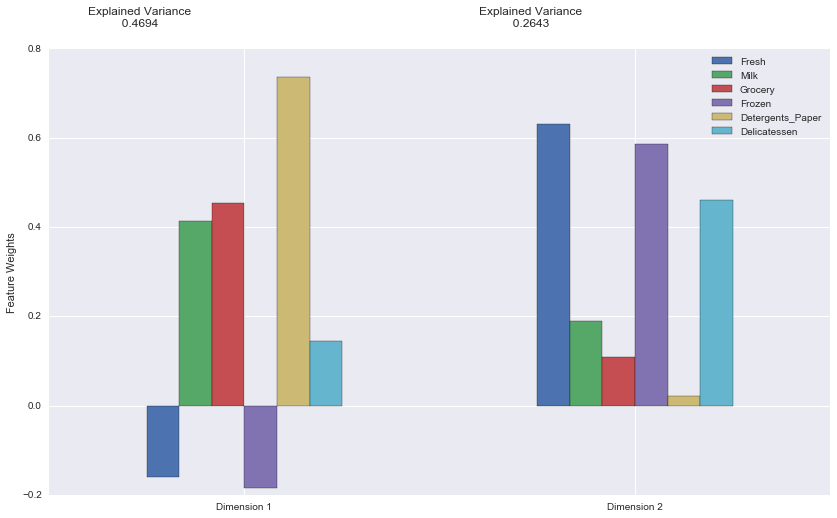

In [14]:
# TODO: Fit PCA to the good data using only two dimensions
pca = PCA(n_components=2).fit(good_data)

# TODO: Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# Generate PCA results plot (to satisfy my own curiousity)
pca_results = rs.pca_results(good_data, pca)

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [15]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-0.0596,2.7584
1,2.9056,0.4151
2,-2.6030,-0.1681


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

The K-means (KM) clustering algorithm is a good general purpose clustering algorithm. Two advantages are simplicity and intuition, given that the only input parameter is the number of clusters. KM is very scalable, and hence works well when there is a large number of datapoints. KM makes 'hard assignments' of each data point to a cluster, meaning on any given iteration, the algorithm is 100% sure which cluster a given data point belongs to.

Gaussian Mixture models (GMM) have the advantage over K-means of incorporating uncertainty into the clustering, which is often more consistent with our mental model of how the world works. For example, if we believe a given datapoint has a certain probability it could be in one cluster and a different probability it could be in another cluster, this type of 'soft assignment' can be made using GMM. GMM is neither as simple as KM (it has many parameters) nor as scalable.

I will use KM clustering here. In the previous section, I observed that 2 PCs can explain 73% of the variance in the data. This suggests that the data will separate into a small number of clusters and hence I would like to use the more simple and intuitive model, given that this is my first clustering assignment and I expect KM will perform quite well for the clustering problem at hand.

For further reading, Scikit-learn provides a good overview of various machine learning clustering methods:
http://scikit-learn.org/stable/modules/clustering.html

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters=2, random_state=3)
clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.cluster_centers_
print "Cluster Centers:"
print centers
print '\n'

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)
print "Sample Cluster Predictions:"
print sample_preds
print '\n'

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data,preds)
print "Silhouette score:"
print score

Cluster Centers:
[[-1.4356127   0.12279478]
 [ 2.13612251 -0.18271272]]


Sample Cluster Predictions:
[0 1 0]


Silhouette score:
0.439525820763


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

**Silhouette Score for Different Numbers of Clusters**  

| Clusters | Score |
| :---------------: | :---------------------:
| 2               |        0.4395           |
| 3               |        0.3658           |
| 4               |        0.3397           |
| 5               |        0.3602           |
| 6               |        0.3638           |
| 8               |        0.3480           |
| 10              |        0.3506           |
| 20              |        0.3511           |

Two clusters provides the best silhouette score.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

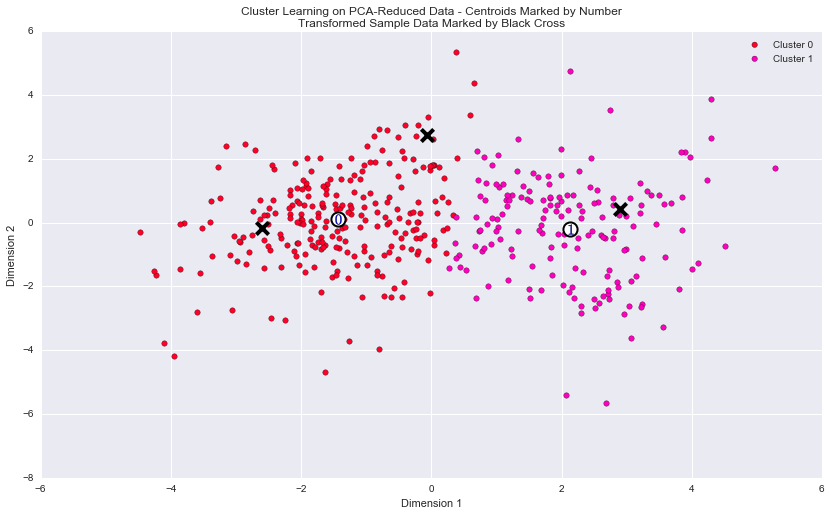

In [17]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [18]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,9337.0,1966.0,2532.0,2197.0,342.0,762.0
Segment 1,4347.0,8124.0,12391.0,952.0,4723.0,1108.0


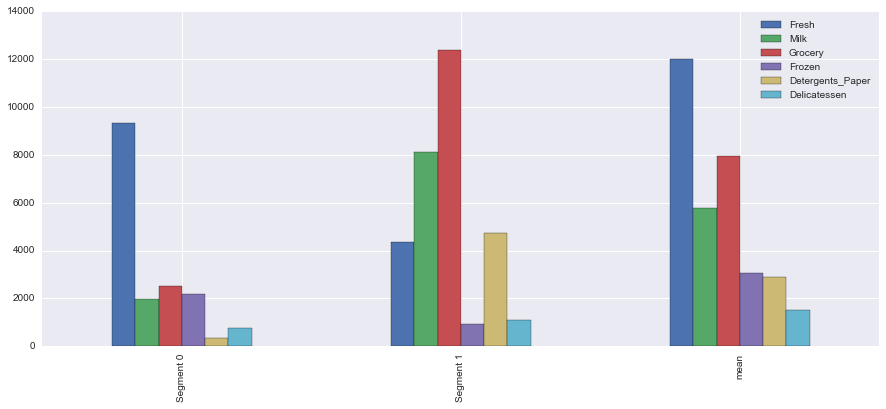

In [19]:
# Visualize the amount of each product purchased for each true_center and compare to the mean:

# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
true_centers = true_centers.append(data.describe().loc['mean'])
_ = true_centers.plot(kind='bar', figsize=(15,6))

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

Segment 0 customers spend well above the median in 'Fresh'and 'Frozen' products and well below the median in the other categories. Segment 1 customers spend well above the median in 'Milk', 'Grocery', 'Detergents_Paper' and 'Delicatessen' products.

Given these profiles, I believe Segment 0 represents the types of establishments that serve prepared meals (such as restaurants), since they would require a higher proportion of fresh and frozen product for preparing those meals, whereas Segment 1 represents retailers (such as groceries) that sell staples (e.g. milk, detergent, paper products) directly to consumers to take home. 

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [20]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Answer:**

I showed earlier that Sample 0 had a 'Fresh' spend well above the median, sample 1 had a 'Grocery' spend well above the median and sample 2 had a 'Frozen' spend well above the median. Based on the cluster centers, this would indicate that sample 0 should be in Cluster 0, sample 1 should be in Cluster 1 and sample 2 should be in Cluster 0 as well and this is in fact how they have been classified, as seen from the code output above.

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:**

The wholesaler appears to have two distinct types of customers. It is expected that a change in delivery would impact each type of customer differently. I would hypothesize that the customer segment purchasing the products with the shorter shelf life (i.e. Segment 0, which buys a much higher amount of 'Fresh' and 'Frozen' product than Segment 1) will be far more sensitive to a reduction in delivery frequency, since they will have to carry older product.

Any A/B test would need to either be focused on the customer segment that is expected to be amenable to a delivery change (i.e. Segment 1) and test customers would be drawn only from that segment or the test should ensure a proportional number of Segment 0 and Segment 1 customers so that the effect of Segment can be deduced from the A/B test results and the distributor would know whether a change could be made with one group and not the other. In other words, it would be erroneous to test only Segment 0 customers in the A/B test and to assume the results of the test would apply equally to Segment 0 and Segment 1 customers, since they have very different spending profiles.

Based on this data, I would recommend the following A/B test to the wholesaler: limit the initial test to customers firmly in Segment 1, since they buy relatively less 'Fresh' and 'Frozen' product and hence are less likely to be as sensitive to delivery frequency. Select a sample group of Segment 1 customers and split the group into two halves. For one half of the test, make no changes to delivery (the control group). For the other half, make the desired changes to delivery (the test group). Monitor the results to see how each group responds to the changes over the test duration. If the test group displays the same level of satisfaction (or perhaps a higher level as they might benefit from fewer deliveries too) then the change can likely be rolled out to any customer in the Segment 1 cluster.

### Question 11
*Assume the wholesale distributor wanted to predict a new feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the data to assist a supervised learning analysis?*  
**Hint:** What other input feature could the supervised learner use besides the six product features to help make a prediction?

**Answer:**

The structure of the data shows that the six product features (i.e. customer purchasing information) can be used to classify customers as either Segment 0 or Segment 1. These clustered data labels for each customer (0 or 1) can now be used as an input to a supervised learning analysis, adding further richness to the data input, and thus potentially resulting in interesting and novel supervised learning output.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

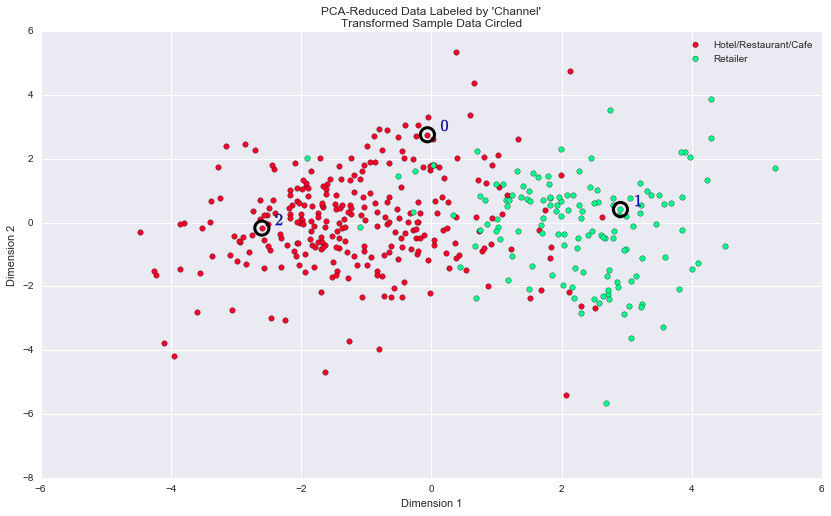

In [21]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

The clustering algorithm and number of clusters (2) that I've chosen compares very well (but not perfectly) with the underlying distribution of 'HoReCa' and 'Retail' customers. Segment 0 from my analysis has a high degree of overlap with 'HoReCa' and Segment 1 has a high degree of overlap with 'Retail'. These classifications are consistent with my earlier definition, where I stated Segment 0 appeared to represent restaurant-type businesses (i.e. 'HoReCa') and Segment 1 appeared to represent grocery store type businesses (i.e. 'Retail'). The figure shows that this overlap is not perfect, since some HoReCa businesses cluster amongst 'Retail' and vice versa and thus would be in the wrong segment is the prediction were based solely on thier channel type, but by and large, the classification and underlying distribution are very consistent with each other.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.